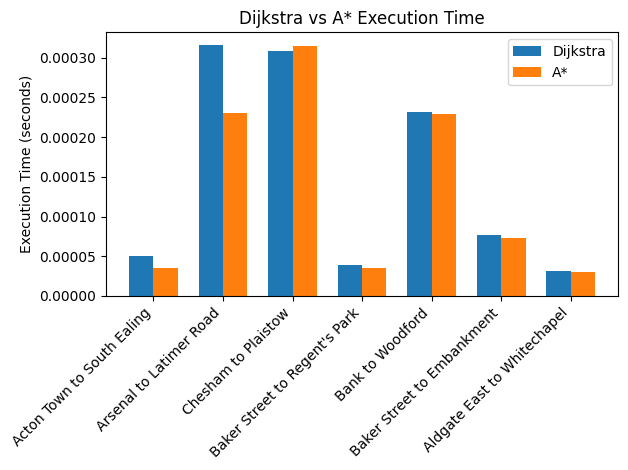

In [3]:

import csv
from math import radians, cos, sin, sqrt, atan2
import time
import matplotlib.pyplot as plt


class PriorityQueue:
    def __init__(self):
        self.elements = []

    def is_empty(self):
        return not self.elements

    def put(self, item, priority):
        self.elements.append((priority, item))
        self.elements.sort(reverse=True)

    def get(self):
        return self.elements.pop()[1]  
def dijkstra(graph, start, end):
    """
    Finds the shortest path from start to end using Dijkstra's algorithm.
    
    Parameters:
    - graph: The graph representation as a dict of dicts.
    - start: The starting node ID.
    - end: The ending node ID.
    
    Returns:
    - The shortest distance from start to end.
    - The path as a list of node IDs from start to end.
    """
    distance = {vertex: float('infinity') for vertex in graph}
    distance[start] = 0
    predecessor = {vertex: None for vertex in graph}
    pq = PriorityQueue()
    pq.put(start, 0)
    
    while not pq.is_empty():
        current_node = pq.get()
        
        if current_node == end:
            break

        for neighbor, weight in graph[current_node].items():
            alt_route = distance[current_node] + weight
            if alt_route < distance[neighbor]:
                distance[neighbor] = alt_route
                predecessor[neighbor] = current_node
                pq.put(neighbor, alt_route)
                
    # Reconstruct path from end to start using predecessors
    path = []
    current = end
    while current is not None:
        path.append(current)
        current = predecessor[current]
    path.reverse()  # Reverse the path to start from the beginning
    
    return distance[end], path


def haversine(coord1, coord2):
    R = 6371000  # Radius of the Earth in meters
    lat1, lon1 = coord1
    lat2, lon2 = coord2

    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2) ** 2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

def heuristic(station_id, destination_id):
    station_coord = (stations[station_id]['latitude'], stations[station_id]['longitude'])
    destination_coord = (stations[destination_id]['latitude'], stations[destination_id]['longitude'])
    return haversine(station_coord, destination_coord)

def reconstruct_path(predecessors, start, end):
    path = []
    while end is not None:
        path.append(end)
        end = predecessors[end]
    return path[::-1] 

def A_Star(graph, source, destination, heuristic):
    open_set = PriorityQueue()
    open_set.put(source, 0 + heuristic(source, destination))  # Corrected this line
    predecessors = {source: None}
    actual_costs = {source: 0}

    while not open_set.is_empty():
        current_node = open_set.get()

        if current_node == destination:
            break  # When the destination is reached, exit the loop

        for neighbor, weight in graph[current_node].items():
            tentative_cost = actual_costs[current_node] + weight
            if neighbor not in actual_costs or tentative_cost < actual_costs[neighbor]:
                actual_costs[neighbor] = tentative_cost
                # Calculate total cost as the sum of actual cost so far and heuristic estimate to the goal
                total_cost = tentative_cost + heuristic(neighbor, destination)
                open_set.put(neighbor, total_cost)
                predecessors[neighbor] = current_node

    return predecessors, reconstruct_path(predecessors, source, destination)




def parse_stations(file_path):
    """
    Parses the stations CSV file and returns a dictionary of stations.
    
    Parameters:
    - file_path: The path to the stations CSV file.
    
    Returns:
    - A dictionary where keys are station IDs and values are dictionaries
      containing latitude, longitude, and name of the station.
    """
    stations = {}
    with open(file_path, mode='r', encoding='utf-8') as infile:
        reader = csv.DictReader(infile)
        for row in reader:
            station_id = int(row["id"])
            stations[station_id] = {
                "latitude": float(row["latitude"]),
                "longitude": float(row["longitude"]),
                "name": row["name"]
            }
    return stations


def parse_connections(file_path):
    """
    Parses the connections CSV file and returns a list of connections.
    
    Parameters:
    - file_path: The path to the connections CSV file.
    
    Returns:
    - A list of tuples, each representing a connection between two stations.
      Each tuple contains (station1, station2, line, time).
    """
    connections = []
    with open(file_path, mode='r', encoding='utf-8') as infile:
        reader = csv.reader(infile)
        next(reader)  # Skip the header
        for row in reader:
            connection = (int(row[0]), int(row[1]), int(row[2]), float(row[3]))
            connections.append(connection)
    return connections

stations_file_path = 'london_stations.csv'
connections_file_path = 'london_connections.csv'

stations = parse_stations(stations_file_path)
connections = parse_connections(connections_file_path)



def build_graph(connections):
    """
    Builds a graph from a list of connections.
    Each connection is a tuple (station1, station2, time).

    Parameters:
    - connections: A list of tuples, where each tuple contains
      (station1, station2, time).

    Returns:
    - A dictionary representing the graph, where keys are station IDs
      and values are dictionaries of neighboring stations and their respective times.
    """
    graph = {}

    for station1, station2, _, time in connections:
        # Initialize station1 and station2 in graph if they don't exist
        if station1 not in graph:
            graph[station1] = {}
        if station2 not in graph:
            graph[station2] = {}

        # Add the edge from station1 to station2 and vice versa
        graph[station1][station2] = time
        graph[station2][station1] = time  # Assuming bidirectional connections

    return graph


graph = build_graph(connections)

def measure_performance(graph, start_id, end_id, heuristic):
    # Measure Dijkstra's algorithm performance
    start_time = time.time()
    _, path_dijkstra = dijkstra(graph, start_id, end_id)
    dijkstra_time = time.time() - start_time

    # Measure A* algorithm performance
    start_time = time.time()
    _, path_astar = A_Star(graph, start_id, end_id, heuristic)
    astar_time = time.time() - start_time

    return dijkstra_time, astar_time

def plot_performance_comparison(labels, dijkstra_times, astar_times, title='Dijkstra vs A* Execution Time'):
    """
    Plots a comparison of execution times between Dijkstra's and A* algorithms.

    Parameters:
    - labels: List of strings representing the labels for each station pair.
    - dijkstra_times: List of execution times for Dijkstra's algorithm.
    - astar_times: List of execution times for A* algorithm.
    - title: (Optional) Title for the plot.
    """
    x = range(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x, dijkstra_times, width, label='Dijkstra')
    rects2 = ax.bar([p + width for p in x], astar_times, width, label='A*')

    # Add some text for labels, title, and custom x-axis tick labels, etc.
    ax.set_ylabel('Execution Time (seconds)')
    ax.set_title(title)
    ax.set_xticks([p + width / 2 for p in x])
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.legend()

    fig.tight_layout()

    plt.show()
    
station_pairs = [
    (1, 234),  # Short distance
    (10, 150),  # Medium distance
    (50, 200),  # Long distance
    (11, 212),  # Same Line, Short Distance
    (13, 301),  # Same Line, Long Distance
    (11, 87),   # Different Lines, No Transfers
    (3, 295),   # Different Lines, Multiple Transfers

]

# Collect data
labels = []
dijkstra_times = []
astar_times = []

for start_id, end_id in station_pairs:
    # Correct lambda function: Accepts two arguments but ignores them and returns 0
    dijkstra_time, _ = measure_performance(graph, start_id, end_id, lambda x, y: 0)
    astar_time, _ = measure_performance(graph, start_id, end_id, heuristic)

    labels.append(f"{stations[start_id]['name']} to {stations[end_id]['name']}")
    dijkstra_times.append(dijkstra_time)
    astar_times.append(astar_time)

# Plot the comparison
plot_performance_comparison(labels, dijkstra_times, astar_times)

In [7]:
def heuristic_func(node, destination, heuristic_dict):
    return heuristic_dict[node]

def reconstruct_path(predecessors, source, destination):
    current_node = destination
    path = [current_node]
    while current_node != source:
        current_node = predecessors[current_node]
        path.append(current_node)
    path.reverse()
    return path

def A_Star_custom(graph, source, destination, heuristic_dict):
    open_set = PriorityQueue()
    open_set.put(source, 0 + heuristic_dict[source])
    predecessors = {source: None}
    actual_costs = {source: 0}

    while not open_set.is_empty():
        current_node = open_set.get()

        if current_node == destination:
            break

        for neighbor, weight in graph[current_node].items():
            tentative_cost = actual_costs[current_node] + weight
            if neighbor not in actual_costs or tentative_cost < actual_costs[neighbor]:
                actual_costs[neighbor] = tentative_cost
                total_cost = tentative_cost + heuristic_func(neighbor, destination, heuristic_dict)
                open_set.put(neighbor, total_cost)
                predecessors[neighbor] = current_node

    return predecessors, reconstruct_path(predecessors, source, destination)

# Define the graph and heuristic as before
graph = {
    0: {1: 1, 2: 4},
    1: {2: 2, 3: 5},
    2: {3: 1},
    3: {}
}
heuristic = {
    0: 7,
    1: 6,
    2: 2,
    3: 0
}
source = 0
destination = 3

# Run the modified A* function
A_Star_custom(graph, source, destination, heuristic)

({0: None, 1: 0, 2: 0, 3: 2}, [0, 2, 3])